In [1]:
# PCA on the whole training dataset with both classes
# https://stats.stackexchange.com/questions/7111/how-to-perform-pca-for-data-of-very-high-dimensionality
import numpy as np
import os
from PIL import Image
import helper
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# width size
w = 512

# height size
h = 512

# number of channels
c = 3


imSize = w * h * c
noImage = 750

In [3]:
print(f"------------------------PCA via covariance matrix-------------------------------")
# read X from folder
X = np.zeros((w * h * c, noImage))

source_train_normal = "./../../../datasets/rosacea-detection/train/normal"
source_train_rosacea = "./../../../datasets/rosacea-detection/train/rosacea"

print("Loading normal faces to X ...")
for i, filename in zip(range(500), os.listdir(source_train_normal)):
    filepath = os.path.join(source_train_normal, filename)
    img = Image.open(filepath)
    X[:, i] = (np.array(img) / 255.0).flatten().copy()
print(f"normal faces loaded.")

print("Loading rosacea faces to X ...")
for i, filename in zip(range(500, 750, 1), os.listdir(source_train_rosacea)):
    filepath = os.path.join(source_train_rosacea, filename)
    img = Image.open(filepath)
    X[:, i] = (np.array(img) / 255.0).flatten().copy()
print(f"rosacea faces loaded.")

------------------------PCA via covariance matrix-------------------------------
Loading normal faces to X ...
normal faces loaded.
Loading rosacea faces to X ...
rosacea faces loaded.


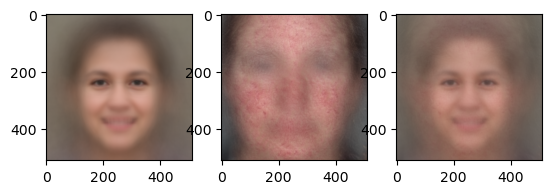

In [4]:
# Mean Vector
meanNormal = np.mean(X[:,:500], 1)
meanRosacea = np.mean(X[:, 500:], 1)
meanFace = np.mean(X, 1)

fig, axs = plt.subplots(1,3)
axs[0].imshow(np.reshape(meanNormal, (w, h, c)))
axs[1].imshow(np.reshape(meanRosacea, (w, h, c)))
axs[2].imshow(np.reshape(meanFace, (w, h, c)))

In [5]:
# center data matrix
for i in range(noImage):
    X[:, i] = X[:, i] - meanFace

In [6]:
# find out the rank of the data matrix
print(f"The rank of the data matrix is: {np.linalg.matrix_rank(X)}")

The rank of the data matrix is: 749


In [7]:
# step 1 : eig, mxm
eVals, eVects = np.linalg.eig(np.matmul(np.transpose(X), X) / (noImage - 1))

In [8]:
# eigenvectors are orthogonal and normalized 

print(np.shape(eVals))
print(np.shape(eVects))
print(np.sum(np.identity(750)-np.matmul(eVects, np.transpose(eVects))))

# eigenvalues are not sorted
is_sorted = lambda a: np.all(a[:-1] >= a[1:])
print(is_sorted(eVals))

# sqrt will have error on one of the eigenvalues which is close to 0
idx = np.where(eVals <= 0)
print(eVals[idx[0][:]])

(750,)
(750, 750)
-4.823437528890994e-13
False
[-1.24344979e-14]


In [9]:
# Sort the eigenvalues and its corresponding eigenvectors

idx = eVals.argsort()[::-1]   
eVals = eVals[idx]
eVects = eVects[:,idx]

In [10]:
# make the last eigenvlues to be positive 0+ for the purpose of using sqrt
# make the corresponding eigenvector 
eVals[-1] = -eVals[-1]
eVects[:, -1] = -eVects[:, -1]
print(np.all(eVals > 0))

True


In [11]:
is_sorted(eVals)

True

In [12]:
# Step 2 : eig. nxn;
# Eigenvectors or Eigenfaces
Evect = np.matmul(X, eVects)

In [13]:
print(np.linalg.norm(Evect[:,0]))

2356.6274350666254


In [14]:
# Step 3 : normalization
Evect_norm = np.zeros((imSize, noImage))
for i in range(noImage):
    Evect_norm[:, i] = Evect[:, i] / np.linalg.norm(Evect[:,i])

In [15]:
print(np.linalg.norm(Evect_norm[:,0]))

1.00000000000001


In [16]:
np.shape(Evect_norm)

(786432, 750)

In [17]:
# get rid of the last eigenvalue which is 0 and the corresponding eigenvector
eVals_ = eVals [:-1]
Evect_norm_ = Evect_norm[:, :-1]

In [18]:
print(np.shape(eVals_))
print(np.shape(Evect_norm_))

(749,)
(786432, 749)


In [19]:
W = np.matmul(Evect_norm_, np.diag(1 / (eVals_ ** (0.5))))

In [20]:
np.shape(W)

(786432, 749)

In [24]:
def whitened_cosine_similarity(u, v):
    W_tu = np.matmul(u,W)
    W_tv = np.matmul(v,W)
    return np.dot(W_tu, W_tv) / (np.linalg.norm(W_tu) * 
                                    np.linalg.norm(W_tv))

In [25]:
# On Val Set
TP_v, TN_v, FP_v, FN_v = 0, 0, 0, 0
val_normal_path = "./../../../datasets/rosacea-detection/val/normal"
count = 0
for filename in os.listdir(val_normal_path):
    count += 1
    file_path = os.path.join(val_normal_path, filename)
    sample = np.array(Image.open(file_path)).flatten() / 255.0
    sim_n = whitened_cosine_similarity(sample, meanNormal)
    sim_r = whitened_cosine_similarity(sample, meanRosacea)
    if sim_r < sim_n: # more like normal
        TN_v += 1
        print(f"sim_r:{sim_r} < sim_n:{sim_n}, {count}th in normal is true negative")

    else: # sim_r > sim_n
        FP_v += 1 
        print(f"sim_r:{sim_r} > sim_n:{sim_n}, {count}th in normal is false positive")
print(f"Val on normal done, True Negative:{TN_v}, False Positive:{FP_v}\n")


count = 0
val_rosacea_path = "./../../../datasets/rosacea-detection/val/rosacea"
for filename in os.listdir(val_rosacea_path):
    count += 1
    file_path = os.path.join(val_rosacea_path, filename)
    sample = np.array(Image.open(file_path)).flatten() /255.0

    sim_n = whitened_cosine_similarity(sample, meanNormal)
    sim_r = whitened_cosine_similarity(sample, meanRosacea)
    if sim_r > sim_n:
        TP_v += 1
        print(f"sim_r:{sim_r} > sim_n:{sim_n}, {count}th in rosacea is true positive")
    else: # sim_r < sim_n
        FN_v += 1
        print(f"sim_r:{sim_r} < sim_n:{sim_n}, {count}th in rosacea is false negative")
print(f"Val on rosacea done, True Positive:{TP_v}, False Negative:{FN_v}\n")

sim_r:0.5754915746988009 < sim_n:0.5811174277718643, 1th in normal is true negative
sim_r:0.5921243871207266 < sim_n:0.5992300610606193, 2th in normal is true negative
sim_r:0.5679984325861761 < sim_n:0.57575209483227, 3th in normal is true negative
sim_r:0.5611293362743516 < sim_n:0.5658082683340931, 4th in normal is true negative
sim_r:0.4936442074057194 < sim_n:0.4984562249667201, 5th in normal is true negative
sim_r:0.5991072874052111 < sim_n:0.6056227077305281, 6th in normal is true negative
sim_r:0.395329050071441 < sim_n:0.39816906018932247, 7th in normal is true negative
sim_r:0.5199406791166261 < sim_n:0.5237043396755864, 8th in normal is true negative
sim_r:0.5212349861189617 < sim_n:0.5275389385871923, 9th in normal is true negative
sim_r:0.3855564003305872 < sim_n:0.38864970597313153, 10th in normal is true negative
sim_r:0.5557581324947537 < sim_n:0.5582643596443447, 11th in normal is true negative
sim_r:0.5053048600962323 < sim_n:0.5107244967477488, 12th in normal is true

In [26]:
# On Test Set
TP_t, TN_t, FP_t, FN_t = 0, 0, 0, 0
test_normal_path = "./../../../datasets/rosacea-detection/test/normal"
count = 0
for filename in os.listdir(test_normal_path):
    count += 1
    file_path = os.path.join(test_normal_path, filename)
    sample = np.array(Image.open(file_path)).flatten() / 255.0
    sim_n = whitened_cosine_similarity(sample, meanNormal)
    sim_r = whitened_cosine_similarity(sample, meanRosacea)
    if sim_r < sim_n: # more like normal
        TN_t += 1
        print(f"sim_r:{sim_r} < sim_n:{sim_n}, {count}th in normal is true negative")

    else: # sim_r > sim_n
        FP_t += 1 
        print(f"sim_r:{sim_r} > sim_n:{sim_n}, {count}th in normal is false positive")
print(f"Test on normal done, True Negative:{TN_t}, False Positive:{FP_t}\n")


count = 0
test_rosacea_path = "./../../../datasets/rosacea-detection/test/rosacea"
for filename in os.listdir(test_rosacea_path):
    count += 1
    file_path = os.path.join(test_rosacea_path, filename)
    sample = np.array(Image.open(file_path)).flatten() /255.0

    sim_n = whitened_cosine_similarity(sample, meanNormal)
    sim_r = whitened_cosine_similarity(sample, meanRosacea)
    if sim_r > sim_n:
        TP_t += 1
        print(f"sim_r:{sim_r} > sim_n:{sim_n}, {count}th in rosacea is true positive")
    else: # sim_r < sim_n
        FN_t += 1
        print(f"sim_r:{sim_r} < sim_n:{sim_n}, {count}th in rosacea is false negative")
print(f"Test on rosacea done, True Positive:{TP_t}, False Negative:{FN_t}\n")

sim_r:0.5203055341046773 < sim_n:0.5266600662508281, 1th in normal is true negative
sim_r:0.2922693002673726 < sim_n:0.29404976998230864, 2th in normal is true negative
sim_r:0.3941780217113139 < sim_n:0.39851764332480055, 3th in normal is true negative
sim_r:0.38834421059150276 < sim_n:0.39406779371937195, 4th in normal is true negative
sim_r:0.4763626257597371 < sim_n:0.48073850443864125, 5th in normal is true negative
sim_r:0.4593646958643801 < sim_n:0.4631893006160579, 6th in normal is true negative
sim_r:0.5718235896128948 < sim_n:0.5762577525927423, 7th in normal is true negative
sim_r:0.39268254479852993 < sim_n:0.39600695870126235, 8th in normal is true negative
sim_r:0.48501493718372546 < sim_n:0.48988964563386994, 9th in normal is true negative
sim_r:0.5292827179176551 < sim_n:0.5332367541314671, 10th in normal is true negative
sim_r:0.4750227288920669 < sim_n:0.48159649914505054, 11th in normal is true negative
sim_r:0.5013397873399373 < sim_n:0.5069514685146772, 12th in nor

In [27]:
accuracy_v, precision_v, recall_v, F1_v = helper.get_performance_metrics(
        TP_v, TN_v, FP_v, FN_v)

accuracy_t, precision_t, recall_t, F1_t = helper.get_performance_metrics(
        TP_t, TN_t, FP_t, FN_t)

result = {       
    "TN_v" : TN_v,
    "TP_v" : TP_v,
    "FP_v" : FP_v,
    "FN_v" : FN_v,
    "accuracy_v" : accuracy_v,
    "precision_v" : precision_v,
    "recall_v" : recall_v,
    "F1_v" : F1_v,

    "TN_t" : TN_t,
    "TP_t" : TP_t,
    "FP_t" : FP_t,
    "FN_t" : FN_t,
    "accuracy_t" : accuracy_t,
    "precision_t" : precision_t,
    "recall_t" : recall_t,
    "F1_t" : F1_t
}

json_object = json.dumps(result, indent = 4)

# writing to file
json_name = f"whitened-cosine.json"
json_path = os.path.join("./../results/",json_name)
with open(json_path,'w') as outfile:
    outfile.write(json_object)